# Generative PC on MNIST

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thebuckleylab/jpc/blob/main/examples/supervised_generative_pc.ipynb)

This notebook demonstrates how to train a neural network with predictive coding to generate MNIST digits.

In [1]:
%%capture
!pip install torch==2.3.1
!pip install torchvision==0.18.1
!pip install matplotlib==3.0.0

In [2]:
import jpc

import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
from diffrax import Heun
import optax

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')  # ignore warnings

## Hyperparameters

We define some global parameters, including network architecture, learning rate, batch size etc.

In [3]:
SEED = 0

LAYER_SIZES = [10, 300, 300, 784]
ACT_FN = "relu"

LEARNING_RATE = 1e-3
BATCH_SIZE = 64
MAX_T1 = 100
TEST_EVERY = 50
N_TRAIN_ITERS = 200

## Dataset

Some utils to fetch and plot MNIST.

In [4]:
#@title data utils


def get_mnist_loaders(batch_size):
    train_data = MNIST(train=True, normalise=True)
    test_data = MNIST(train=False, normalise=True)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return train_loader, test_loader


class MNIST(datasets.MNIST):
    def __init__(self, train, normalise=True, save_dir="data"):
        if normalise:
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.1307), std=(0.3081)
                    )
                ]
            )
        else:
            transform = transforms.Compose([transforms.ToTensor()])
        super().__init__(save_dir, download=True, train=train, transform=transform)

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        img = torch.flatten(img)
        label = one_hot(label)
        return img, label


def one_hot(labels, n_classes=10):
    arr = torch.eye(n_classes)
    return arr[labels]


def plot_mnist_img_preds(imgs, labels, n_imgs=10):
    plt.figure(figsize=(20, 2))
    for i in range(n_imgs):
        plt.subplot(1, n_imgs, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imgs[i].reshape(28, 28), cmap=plt.cm.binary_r)
        plt.xlabel(jnp.argmax(labels, axis=1)[i], fontsize=16)
    plt.show()


## Network

For `jpc` to work, we need to provide a network with callable layers. This is easy to do with the PyTorch-like `nn.Sequential()` in [Equinox](https://github.com/patrick-kidger/equinox). For example, we can define a ReLU MLP with two hidden layers as follows

In [5]:
key = jax.random.PRNGKey(SEED)
key, *subkeys = jax.random.split(key, 4)
network = [
    nn.Sequential(
        [
            nn.Linear(10, 300, key=subkeys[0]),
            nn.Lambda(jax.nn.relu)
        ],
    ),
    nn.Sequential(
        [
            nn.Linear(300, 300, key=subkeys[1]),
            nn.Lambda(jax.nn.relu)
        ],
    ),
    nn.Linear(300, 784, key=subkeys[2]),
]
print(network)

[Sequential(
  layers=(
    Linear(
      weight=f32[300,10],
      bias=f32[300],
      in_features=10,
      out_features=300,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Sequential(
  layers=(
    Linear(
      weight=f32[300,300],
      bias=f32[300],
      in_features=300,
      out_features=300,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Linear(
  weight=f32[784,300],
  bias=f32[784],
  in_features=300,
  out_features=784,
  use_bias=True
)]


You can also use the utility `jpc.get_fc_network` to define an MLP or fully connected network with some activation functions.

In [6]:
network = jpc.make_mlp(key, LAYER_SIZES, act_fn="relu")
print(network)

[Sequential(
  layers=(
    Linear(
      weight=f32[300,10],
      bias=f32[300],
      in_features=10,
      out_features=300,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Sequential(
  layers=(
    Linear(
      weight=f32[300,300],
      bias=f32[300],
      in_features=300,
      out_features=300,
      use_bias=True
    ),
    Lambda(fn=<wrapped function relu>)
  )
), Sequential(
  layers=(
    Linear(
      weight=f32[784,300],
      bias=f32[784],
      in_features=300,
      out_features=784,
      use_bias=True
    ),
    Lambda(fn=Identity())
  )
)]


## Train and test

A PC network can be trained in a single line of code with `jpc.make_pc_step()`. See the documentation for more. Similarly, we can use `jpc.test_generative_pc()` to get some test metrics including accuracy of inferred labels and image predictions. Note that these functions are already "jitted" for performance.

Below we simply wrap each of these functions in our training and test loops, respectively. Note that to train in an unsupervised way, you can simply remove the `input` from `jpc.make_pc_step()` and the `evaluate()` script.

In [7]:
def evaluate(key, layer_sizes, batch_size, network, test_loader, max_t1):
    test_acc = 0
    for batch_id, (img_batch, label_batch) in enumerate(test_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()

        acc, img_preds = jpc.test_generative_pc(
            model=network,
            input=label_batch,
            output=img_batch,
            key=key,
            layer_sizes=layer_sizes,
            batch_size=batch_size,
            max_t1=max_t1
        )
        test_acc += acc

    avg_test_acc = test_acc / len(test_loader)

    return avg_test_acc, label_batch, img_preds


def train(
      key,
      layer_sizes,
      batch_size,
      network,
      lr,
      max_t1,
      test_every,
      n_train_iters
):
    optim = optax.adam(lr)
    opt_state = optim.init(
        (eqx.filter(network, eqx.is_array), None)
    )
    train_loader, test_loader = get_mnist_loaders(batch_size)

    for iter, (img_batch, label_batch) in enumerate(train_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()

        result = jpc.make_pc_step(
            model=network,
            optim=optim,
            opt_state=opt_state,
            input=label_batch,
            output=img_batch,
            max_t1=max_t1
        )
        network, optim, opt_state = result["model"], result["optim"], result["opt_state"]
        train_loss = result["loss"]
        if ((iter+1) % test_every) == 0:
            avg_test_acc, test_label_batch, img_preds = evaluate(
                key,
                layer_sizes,
                batch_size,
                network,
                test_loader,
                max_t1=max_t1
            )
            print(
                f"Train iter {iter+1}, train loss={train_loss:4f}, "
                f"avg test accuracy={avg_test_acc:4f}"
            )
            if (iter+1) >= n_train_iters:
                break

    plot_mnist_img_preds(img_preds, test_label_batch)
    return network


## Run

Train iter 50, train loss=0.631369, avg test accuracy=74.959938
Train iter 100, train loss=0.607500, avg test accuracy=79.206734
Train iter 150, train loss=0.577637, avg test accuracy=80.418671
Train iter 200, train loss=0.555235, avg test accuracy=79.236778


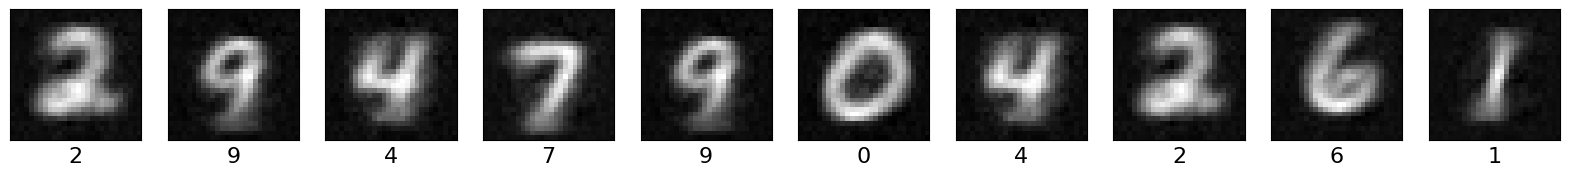

In [8]:
network = train(
    key=key,
    layer_sizes=LAYER_SIZES,
    batch_size=BATCH_SIZE,
    network=network,
    lr=LEARNING_RATE,
    max_t1=MAX_T1,
    test_every=TEST_EVERY,
    n_train_iters=N_TRAIN_ITERS
)